In [89]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob,os
import scipy.ndimage.filters as filters
import scipy.ndimage.measurements as measurements
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion, binary_opening
import time
import json

In [80]:
def readfile(folder,filename):
    img=Image.open(folder+filename)
    
    # fromstring supposed to be faster.
    # See https://stackoverflow.com/questions/13550376/pil-image-to-array-numpy-array-to-array-python
    imgdata=np.fromstring(img.tobytes(),dtype=np.uint8)
    imgdata=imgdata.reshape((img.size[1],img.size[0]))
    identifier=filename.split(".png")[0]
    timestamp=float(identifier.split("_")[1])/1000.0
    shot=int(identifier.split("_")[3])
    return {'TIMESTAMP':timestamp, 'shot':shot, 'ImageData':imgdata}

def getCenter(array,percentile):
    threshold=np.percentile(array,percentile)
    thresholdmask=array<threshold # Mask pixels having brightness less than given threshold
    openingmask=binary_opening(thresholdmask) # Apply dilation-erosion to exclude possible noise
    temp=np.ma.array(array,mask=openingmask)
    [COM_Y,COM_X]=measurements.center_of_mass(temp)
    return {'COM_X':COM_X, 'COM_Y':COM_Y}

def getFeature(folder,filename):
    metadata=readfile(folder,filename)
    percentile=99.9
    centers=getCenter(metadata['ImageData'],percentile)
    return {'TIMESTAMP':metadata['TIMESTAMP'], 'shot':metadata['shot'], 'X':centers['COM_X'], 'Y':centers['COM_Y']}

def deleteFile(folder,filename):
    os.remove(folder+filename)

In [81]:
#master_folder='D:\\test_imgs\\'
folder='E:\\CsPy\\BlackflyControl\\test_img\\'
os.chdir(folder)

#filename=glob.glob("*.png")[filenumber]
filenames=glob.glob("*.png")

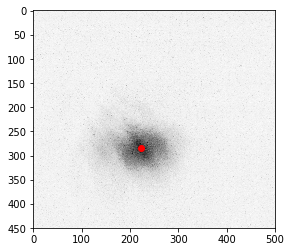

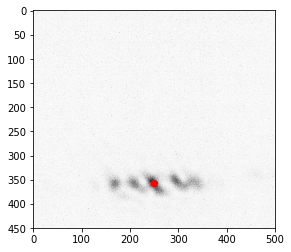

In [82]:
percentile=99.9
rawdata=readfile(folder,filenames[0])['ImageData']
[COM_X,COM_Y]=[getCenter(rawdata,percentile)['COM_X'],getCenter(rawdata,percentile)['COM_Y']]
plt.imshow(rawdata,cmap='Greys')
plt.scatter(COM_X,COM_Y,marker='o',color='red')
plt.show()
percentile=99.9
rawdata=readfile(folder,filenames[1])['ImageData']
[COM_X,COM_Y]=[getCenter(rawdata,percentile)['COM_X'],getCenter(rawdata,percentile)['COM_Y']]
plt.imshow(rawdata,cmap='Greys')
plt.scatter(COM_X,COM_Y,marker='o',color='red')
plt.show()

In [86]:
def process_all(folder,delete):
    os.chdir(folder)
    filenames_init=glob.glob("*.png")
    filenum_init=len(filenames_init)
    if filenum_init==0:
        print "No png file found"
        return
    else:    
        datalist=[]
        for filename in filenames_init:
                datalist.append(getFeature(folder,filename))
                if delete:
                    print "Processed file being deleted:{}".format(filename)
                    deleteFile(folder,filename)
        return datalist

In [92]:
result=process_all(folder,False)

#dump to json
with open('data.txt','w') as outfile:
    json.dump(result,outfile)

    